In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
pd.set_option('display.max_rows', None)

In [2]:
##### Setup #####
df = pd.read_csv("../data/data_ilr_transformed/combined_data__resid_with_time.csv")
print(f"Dataset succesfully imported. Shape: {df.shape}")
print(" - Number of experiments:", len(df["Experiment"].unique()))
print(" - Number of unique time points:", len(df["time"].unique()))

# Variables
original_DVs = ["ina", "na", "nna", "enna"]
ilr_columns = ['ilr1', 'ilr2', 'ilr3']
ilr_resid_columns = ['ilr1_residual', 'ilr2_residual', 'ilr3_residual']
control_columns = ['excluded', 'injustice', 'personal', 'violence']

Dataset succesfully imported. Shape: (19265, 21)
 - Number of experiments: 8
 - Number of unique time points: 15


## Feature Engineering

In [3]:
##### Feature Engineering #####
# Additional time-based feature: time point relative to the total duration for each participant
df['relative_time'] = df.groupby('ID')['time'].transform(lambda x: x / x.max())

# Time points per experiment
experiment_timepoints = df.groupby('Experiment')['time'].max()
df['total_timepoints'] = df['Experiment'].map(experiment_timepoints)

# Calculate mean and standard deviation per participant (ID) for each ilr column
for column_group in [ilr_columns, ilr_resid_columns]:
    for col in column_group:
        df[f'{col}_mean'] = df.groupby('ID')[col].transform('mean')
        df[f'{col}_std'] = df.groupby('ID')[col].transform('std')
        df[f'{col}_min'] = df.groupby('ID')[col].transform('min')
        df[f'{col}_max'] = df.groupby('ID')[col].transform('max')

# Moving Average or Exponential Moving Average (EMA)
window_size = 1
for col in ilr_resid_columns:
    df[f'{col}_moving_avg'] = df.groupby('ID')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    df[f'{col}_ema'] = df.groupby('ID')[col].transform(lambda x: x.ewm(span=window_size, adjust=False).mean())
ilr_moving_avg_cols = ['ilr1_residual_moving_avg', 'ilr2_residual_moving_avg', 'ilr3_residual_moving_avg']
ilr_ema_cols = ['ilr1_residual_ema', 'ilr2_residual_ema', 'ilr3_residual_ema']

# Fourier transformation
fourier_components = 1
# Compute Fourier transform for each 'ilr' variable per participant
for column_group in [ilr_moving_avg_cols, ilr_ema_cols]:
    for col in column_group:
        def compute_fourier(x):
            fft_vals = np.fft.fft(x)
            # Retain only the first N components (real and imaginary parts)
            return np.hstack([fft_vals.real[:fourier_components], fft_vals.imag[:fourier_components]])

        # Apply Fourier transformation and store as separate columns
        fourier_df = (
            df.groupby('ID')[col]
            .apply(lambda x: compute_fourier(x.values))
            .apply(pd.Series)
            .rename(columns=lambda i: f'{col}_fourier_{i+1}')
        )

        # Add Fourier features back to the dataframe
        df = df.join(fourier_df, on='ID')

# Fourier transformation
fourier_components = 2
# Compute Fourier transform for each 'ilr' variable per participant
for column_group in [ilr_moving_avg_cols, ilr_ema_cols]:
    for col in column_group:
        def compute_fourier(x):
            fft_vals = np.fft.fft(x)
            # Retain only the first N components (real and imaginary parts)
            return np.hstack([fft_vals.real[:fourier_components], fft_vals.imag[:fourier_components]])

        # Apply Fourier transformation and store as separate columns
        fourier_df = (
            df.groupby('ID')[col]
            .apply(lambda x: compute_fourier(x.values))
            .apply(pd.Series)
            .rename(columns=lambda i: f'{col}_fourier_2_{i+1}')
        )

        # Add Fourier features back to the dataframe
        df = df.join(fourier_df, on='ID')

In [4]:
summary_table = df.describe().T[['mean', 'std', 'min', 'max']]
print(summary_table)

                                              mean         std        min  \
time                                  6.619621e+00    4.023941   1.000000   
ID                                    7.170360e+02  472.867254   1.000000   
ina                                   5.847288e+00   17.458759   0.000000   
na                                    2.152593e+01   29.335168   0.000000   
nna                                   5.980509e+01   34.037772   0.000000   
enna                                  1.289437e+01   23.398656   0.000000   
ilr1                                  1.022723e+00    1.848018  -3.547032   
ilr2                                  2.158309e+00    1.804457  -3.535202   
ilr3                                 -7.767114e-01    1.863233  -3.404104   
excluded                              6.746480e-01    0.274247   0.000000   
injustice                             6.120555e-01    0.353733   0.000000   
personal                              6.281573e-01    0.278882   0.000000   

In [5]:
##### Prepare Time Series Data for Clustering #####
feature_columns = [
    'relative_time',
    # 'total_timepoints',
    # 'ilr1_residual_mean', 'ilr2_residual_mean', 'ilr3_residual_mean',
    'ilr3_residual_mean',
    # 'ilr1_residual_std', 'ilr2_residual_std', 'ilr3_residual_std',
    # 'ilr1_residual_min', 'ilr2_residual_min', 'ilr3_residual_min',
    # 'ilr3_residual_min',
    # 'ilr1_residual_max', 'ilr2_residual_max', 'ilr3_residual_max',
    'ilr3_residual_max',

    # 'ilr1_residual_moving_avg_fourier_1', 'ilr2_residual_moving_avg_fourier_1', 'ilr3_residual_moving_avg_fourier_1',

    'ilr1_residual_ema_fourier_1', 'ilr2_residual_ema_fourier_1', # 'ilr3_residual_ema_fourier_1',
    # 'ilr3_residual_ema_2_fourier_1', # 'ilr3_residual_ema_2_fourier_2', # 
    # 'ilr3_residual_ema_2_fourier_4'
    # 'ilr1_residual_ema_fourier_2', 'ilr2_residual_ema_fourier_2', 'ilr3_residual_ema_fourier_2'
]
print("====================")
print(f"{len(feature_columns)} features used:")
print(feature_columns)

feature_columns_to_scale = [
    'relative_time',
    'ilr1_residual_mean', 'ilr2_residual_mean', 'ilr3_residual_mean',
    'ilr1_residual_std', 'ilr2_residual_std', 'ilr3_residual_std',
    'ilr1_residual_min', 'ilr2_residual_min', 'ilr3_residual_min',
    'ilr1_residual_max', 'ilr2_residual_max', 'ilr3_residual_max',
    'ilr1_residual_moving_avg_fourier_1', 'ilr2_residual_moving_avg_fourier_1', 'ilr3_residual_moving_avg_fourier_1',
    'ilr1_residual_ema_fourier_1', 'ilr2_residual_ema_fourier_1', 'ilr3_residual_ema_fourier_1',

    # 'ilr3_residual_ema_2_fourier_1', 'ilr3_residual_ema_2_fourier_2', 'ilr3_residual_ema_2_fourier_4'
    # 'ilr1_residual_moving_avg_fourier_2', 'ilr2_residual_moving_avg_fourier_2', 'ilr3_residual_moving_avg_fourier_2',
    # 'ilr1_residual_ema_fourier_2', 'ilr2_residual_ema_fourier_2', 'ilr3_residual_ema_fourier_2'
]
df[feature_columns_to_scale] = RobustScaler().fit_transform(df[feature_columns_to_scale])

5 features used:
['relative_time', 'ilr3_residual_mean', 'ilr3_residual_max', 'ilr1_residual_ema_fourier_1', 'ilr2_residual_ema_fourier_1']


In [6]:
# Compute the correlation matrix
correlation_matrix = df[feature_columns].corr()

# Identify highly correlated features (threshold = 0.8)
highly_correlated = correlation_matrix.abs().unstack().sort_values(ascending=False)
print(highly_correlated[highly_correlated > 0.8])

relative_time                relative_time                  1.0
ilr3_residual_mean           ilr3_residual_mean             1.0
ilr1_residual_ema_fourier_1  ilr1_residual_ema_fourier_1    1.0
ilr3_residual_max            ilr3_residual_max              1.0
ilr2_residual_ema_fourier_1  ilr2_residual_ema_fourier_1    1.0
dtype: float64


In [7]:
from tslearn.metrics import dtw, dtw_path
import numpy as np

def dtw_silhouette_score(X, labels):
    n_samples = len(X)
    if n_samples <= 1:  # Handle cases with only one or zero samples
        return np.nan
    silhouettes = []
    for i in range(n_samples):
        label_i = labels[i]
        a_i = 0
        count_a = 0
        for j in range(n_samples):
            if i != j and labels[j] == label_i:  # Exclude self-comparison
                a_i += dtw(X[i], X[j])
                count_a += 1
        if count_a == 0:  # Avoid division by zero if there's only one element in the cluster
            a_i = 0
        else:
            a_i /= count_a

        b_i = np.inf
        for label_j in set(labels):
            if label_j != label_i:
                b_j = 0
                count_b = 0
                for k in range(n_samples):
                    if labels[k] == label_j:
                        b_j += dtw(X[i], X[k])
                        count_b += 1
                if count_b > 0:
                    b_j /= count_b
                    b_i = min(b_i, b_j)
        if b_i == np.inf:
            s_i = 0.0
        else:
            s_i = (b_i - a_i) / max(a_i, b_i) if max(a_i, b_i) != 0 else 0.0 # Avoid division by zero
        silhouettes.append(s_i)
    return np.nanmean(silhouettes)


In [8]:
time_series_data = []
grouped = df.groupby("ID")

# Preprocess the time series data for each participant
for participant, group in grouped:
    group_sorted = group.sort_values("time")
    time_series = group_sorted[feature_columns].values
    
    # Pad or truncate each participant's time series to the same length
    max_length = 15 # The 'time' in the Experiments ranges from 6 to 15
    if len(time_series) < max_length:
        time_series = np.pad(time_series, ((0, max_length - len(time_series)), (0, 0)), 'constant', constant_values=np.nan)
    else:
        time_series = time_series[:max_length]
    
    time_series_data.append(time_series)

# Convert to numpy array for clustering
time_series_data = np.array(time_series_data)

In [9]:
##### Clustering #####
n_clusters = 3
print("====================")
print("Number of clusters:", n_clusters)
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
labels = model.fit_predict(time_series_data)
# Adding labels to the original DataFrame for analysis:
df["cluster"] = df["ID"].map(dict(zip(grouped.groups.keys(), labels)))

# Create a summary of the number of participants from each experiment within each cluster
print("====================")
print("Clustering summaries:")
experiment_cluster_summary = df.groupby(['cluster', 'Experiment']).size().unstack(fill_value=0)
print(experiment_cluster_summary)

# Compute the cluster-wise percentages for each experiment
experiment_cluster_summary_percentages = experiment_cluster_summary.div(experiment_cluster_summary.sum(axis=0), axis=1) * 100
experiment_cluster_summary_percentages = experiment_cluster_summary_percentages.round(1)
print(experiment_cluster_summary_percentages)

# Count the number of participants in each cluster
cluster_counts = df["cluster"].value_counts()
print(cluster_counts)
cluster_summary = df.groupby("cluster")[["ina", "na", "nna", "enna", "ilr1", "ilr2", "ilr3"]].mean()
print(cluster_summary)



##### Evaluation (per study!) #####
silhouette_scores = []
davies_bouldin_scores = []
dtw_silhouette_scores = []

# Assume you have a variable `participant_ids` which stores the participant IDs in the exact order they appear in `time_series_data` and `labels`.
grouped = df.groupby("ID")
participant_ids = list(grouped.groups.keys())  # Ensure this matches the order used to build time_series_data
id_to_index = {pid: i for i, pid in enumerate(participant_ids)}
experiments = df['Experiment'].unique()

for exp in experiments:
    # Get participant IDs belonging to this experiment
    exp_ids = df.loc[df['Experiment'] == exp, 'ID'].unique()
    
    # Extract their original time series directly from df, no padding
    participant_series = []
    exp_labels = []
    
    for pid in exp_ids:
        # Extract participant's original data (sorted by time)
        p_data = df[df['ID'] == pid].sort_values('time')[feature_columns].values
        
        # Remove any rows that contain NaNs if present
        # (If your original dataset had no NaNs and you only introduced them via padding,
        # this step might not be necessary. But we keep it just in case.)
        p_data = p_data[~np.isnan(p_data).any(axis=1)]
        
        if len(p_data) == 0:
            # If a participant has no valid rows left, skip them (or handle differently)
            continue
        
        participant_series.append(p_data)
        
        # Retrieve the cluster label assigned to this participant
        # and store in exp_labels
        p_index = id_to_index[pid]
        exp_labels.append(labels[p_index])
        
    # Find the minimum length of sequences in this experiment
    lengths = [arr.shape[0] for arr in participant_series]
    min_len = min(lengths)
    print(f"Minimum length in Experiment {exp}: {min_len}")
    
    # Truncate all series to the minimal length
    truncated_series = [arr[:min_len] for arr in participant_series]
    
    # Flatten each participant's truncated time series into a single vector
    # Resulting shape: (n_participants, min_len * n_features)
    data_matrix = np.array([t.flatten() for t in truncated_series])
    exp_labels = np.array(exp_labels)
    
    # Compute Silhouette and Davies-Bouldin Scores
    # Note: These metrics are not DTW-based, but a simple Euclidean flattening.
    # If you want a DTW-based approach, you'd need a custom scoring function.
    try:
        sil = silhouette_score(data_matrix, exp_labels)
    except ValueError:
        sil = np.nan
    try:
        db = davies_bouldin_score(data_matrix, exp_labels)
    except ValueError:
        db = np.nan

    try:
        dtw_sil = dtw_silhouette_score(truncated_series, exp_labels)
    except ValueError:
        db = np.nan
    
    print(f"Experiment {exp}: DTW Silhouette Score = {dtw_sil}")
    dtw_silhouette_scores.append(dtw_sil)

    print(f"Experiment {exp}: Silhouette Score = {sil}, Davies-Bouldin Score = {db}")
    silhouette_scores.append(sil)
    davies_bouldin_scores.append(db)

# Calculating average and range
silhouette_avg = sum(silhouette_scores) / len(silhouette_scores)
davies_bouldin_avg = sum(davies_bouldin_scores) / len(davies_bouldin_scores)

print("silhouette_scores")
print("average:", silhouette_avg)
print("max:", max(silhouette_scores))
print("min:", min(silhouette_scores))

print("davies_bouldin_scores")
print("average:", davies_bouldin_avg)
print("max:", max(davies_bouldin_scores))
print("min:", min(davies_bouldin_scores))

dtw_silhouette_avg = np.nanmean(dtw_silhouette_scores)
print("====================")
print("DTW silhouette_scores")
print("average:", dtw_silhouette_avg)
print("max:", np.nanmax(dtw_silhouette_scores))
print("min:", np.nanmin(dtw_silhouette_scores))
print("====================")

Number of clusters: 3
Clustering summaries:
Experiment    1    2    3     4     5     6    7    8
cluster                                              
0           690  330  285  1350   500   264  301  120
1           735  570  615  1770  1100  1240  784  354
2           960  600  780  2475  1810   712  602  318
Experiment     1     2     3     4     5     6     7     8
cluster                                                   
0           28.9  22.0  17.0  24.1  14.7  11.9  17.8  15.2
1           30.8  38.0  36.6  31.6  32.3  56.0  46.5  44.7
2           40.3  40.0  46.4  44.2  53.1  32.1  35.7  40.2
cluster
2    8257
1    7168
0    3840
Name: count, dtype: int64
               ina         na        nna       enna      ilr1      ilr2  \
cluster                                                                   
0        18.488281  15.043490  41.510156  24.958073 -0.145367  1.296879   
1         2.254464  34.004046  59.712333   4.224470  1.907739  1.956234   
2         3.087441  13.7082

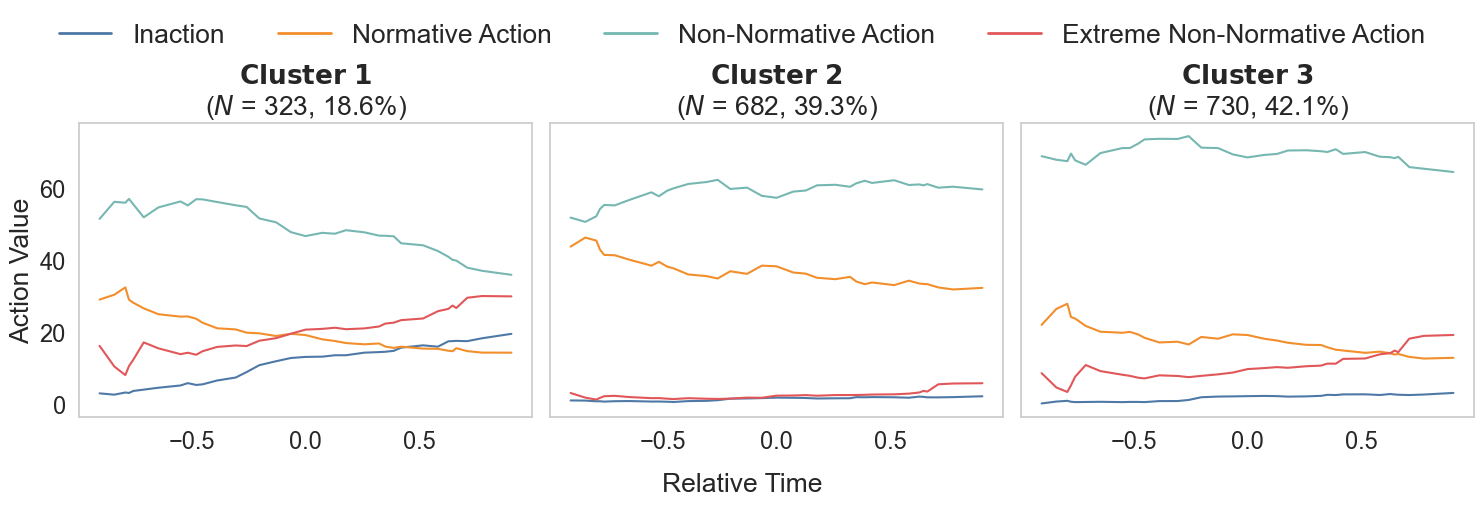

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define font properties
font_size = 19

# Set Seaborn style
sns.set(style="whitegrid")

# Parameters
n_clusters = 3
alpha = 0.05  # Smoothing factor for EMA

# Set up a grid for side-by-side plots
fig, axes = plt.subplots(1, n_clusters, figsize=(15, 5), sharey=True)

# Define colors for the action options
colors = {
    "ina": "#4E79A7",  # Muted Blue
    "na": "#F28E2B",  # Soft Orange
    "nna": "#76B7B2",  # Teal
    "enna": "#E15759",  # Soft Red
}

# Calculate the number of unique IDs per cluster
id_counts = df.groupby('cluster')['ID'].nunique()
total_ids = df['ID'].nunique()

# Loop through clusters
for cluster, ax in enumerate(axes):
    cluster_data = df[df['cluster'] == cluster]
    mean_relative = cluster_data.groupby('relative_time')[['ina', 'na', 'nna', 'enna']].mean()
    
    # Apply Exponential Moving Average (EMA) smoothing
    mean_smooth_ema = mean_relative.apply(lambda x: x.ewm(alpha=alpha).mean())
    
    # Plot EMA smoothed series for each action option
    for action, color in colors.items():
        ax.plot(
            mean_relative.index, mean_smooth_ema[action], 
            label=action, color=color, linestyle="-"
        )
    
    # Formatting for each subplot
    
    percentage = (id_counts[cluster] / total_ids) * 100

    # Formatting for each subplot
    ax.set_title(
        r"$\bf{Cluster\ " + str(cluster + 1) + r"}$" + "\n" + 
        r"($\it{N}$" + f" = {id_counts[cluster]}, {percentage:.1f}%)",
        fontsize=font_size
    )



    if cluster == 0:  # Add Y-axis label only to the first plot
        ax.set_ylabel("Action Value", fontsize=font_size)
    ax.tick_params(axis='both', labelsize=font_size - 2)
    ax.grid(False)

# Add a common x-axis label
fig.text(0.5, 0.01, "Relative Time", ha="center", fontsize=font_size)

# Add a legend
action_labels = {
    "ina": "Inaction",
    "na": "Normative Action",
    "nna": "Non-Normative Action",
    "enna": "Extreme Non-Normative Action",
}

fig.legend(
    handles=[plt.Line2D([0], [0], color=color, linestyle="-", lw=2) for color in colors.values()],
    labels=list(action_labels.values()),  # Use descriptive labels
    loc="upper center", ncol=4, frameon=False, fontsize=font_size
)

# Adjust layout
fig.tight_layout(rect=[0, 0.05, 1, 0.9])  # Leave space for the legend and the common x-label
plt.show()


In [11]:
# Step 1: Prepare your time series data as before
time_series_data = []
grouped = df.groupby("ID")

# Define the range for possible number of clusters
inertia = []
cluster_range = range(1, 6)  # Test 1 to 10 clusters; adjust as needed

for n_clusters in cluster_range:
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
    model.fit(time_series_data)
    inertia.append(model.inertia_)  # Append the inertia for each model

# Step 4: Plot the inertia to find the "elbow"
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.title("Elbow Method for Optimal Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Within-Cluster Distance)")
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
##### Evaluation (per experiment) #####
def dtw_distance_ignore_nans(ts1, ts2):
    mask = ~np.isnan(ts1).any(axis=1) & ~np.isnan(ts2).any(axis=1)
    if np.sum(mask) == 0:
        return 1e6
    ts1_clean = ts1[mask]
    ts2_clean = ts2[mask]
    ts1_reduced = np.linalg.norm(ts1_clean, axis=1)
    ts2_reduced = np.linalg.norm(ts2_clean, axis=1)
    return dtw(ts1_reduced, ts2_reduced)

def compute_pairwise_dtw_distances(subset_data):
    n_samples = subset_data.shape[0]
    dist_matrix = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            dist = dtw_distance_ignore_nans(subset_data[i], subset_data[j])
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist
    return dist_matrix

def dunn_index(distance_matrix, subset_labels):
    unique_clusters = np.unique(subset_labels)
    cluster_diameters = []
    for c in unique_clusters:
        cluster_points = np.where(subset_labels == c)[0]
        if len(cluster_points) > 1:
            dist_within = distance_matrix[np.ix_(cluster_points, cluster_points)]
            cluster_diameters.append(dist_within.max())
        else:
            cluster_diameters.append(0.0)

    inter_cluster_distances = []
    for i in range(len(unique_clusters)):
        for j in range(i+1, len(unique_clusters)):
            c1 = unique_clusters[i]
            c2 = unique_clusters[j]
            points_c1 = np.where(subset_labels == c1)[0]
            points_c2 = np.where(subset_labels == c2)[0]
            dist_between = distance_matrix[np.ix_(points_c1, points_c2)].min()
            inter_cluster_distances.append(dist_between)

    if not inter_cluster_distances:
        return np.nan

    min_inter = np.min(inter_cluster_distances)
    max_intra = np.max(cluster_diameters)
    if max_intra == 0:
        return float('inf')
    return min_inter / max_intra

# Per-experiment evaluation
experiments = df['Experiment'].unique()
id_to_index = {pid: i for i, pid in enumerate(participant_ids)}

for exp in experiments:
    exp_ids = df.loc[df['Experiment'] == exp, 'ID'].unique()
    # Extract subset of time_series_data and labels
    exp_indices = [id_to_index[pid] for pid in exp_ids if pid in id_to_index]
    if len(exp_indices) < 2:
        print(f"Experiment {exp}: Not enough participants for evaluation.")
        continue

    subset_data = time_series_data[exp_indices]
    subset_labels = labels[exp_indices]

    exp_distance_matrix = compute_pairwise_dtw_distances(subset_data)
    exp_dunn = dunn_index(exp_distance_matrix, subset_labels)
    print(f"Experiment {exp}: Dunn Index = {exp_dunn}")


TypeError: list indices must be integers or slices, not list

In [ ]:

##### Plotting #####
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

n_clusters = 3
alpha = 0.1  # Smoothing factor for EMA
savgol_window = 3  # Window length for Savitzky-Golay filter
savgol_polyorder = 1  # Polynomial order for Savitzky-Golay filter

for cluster in range(n_clusters):
    cluster_data = df[df['cluster'] == cluster]
    
    # mean_relative = cluster_data.groupby('relative_time')[['ilr1', 'ilr2', 'ilr3']].mean()
    mean_relative = cluster_data.groupby('relative_time')[['ina', 'na', 'nna', 'enna']].mean()
    
    # Apply Exponential Moving Average (EMA) smoothing
    mean_ilr_smooth_ema = mean_relative.apply(lambda x: x.ewm(alpha=alpha).mean())
    
    # Plot the original and smoothed series for each ILR variable in the cluster
    plt.figure(figsize=(12, 6))
    
    # Plot EMA smoothed series3
    # plt.plot(mean_relative.index, mean_ilr_smooth_ema["ilr1"], label="ILR1 (EMA)", linestyle="--", color="blue")
    # plt.plot(mean_relative.index, mean_ilr_smooth_ema["ilr2"], label="ILR2 (EMA)", linestyle="--", color="orange")
    # plt.plot(mean_relative.index, mean_ilr_smooth_ema["ilr3"], label="ILR3 (EMA)", linestyle="--", color="green")

    plt.plot(mean_relative.index, mean_ilr_smooth_ema["ina"], label="ina (EMA)", linestyle="--", color="blue")
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["na"], label="na (EMA)", linestyle="--", color="orange")
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["nna"], label="nna (EMA)", linestyle="--", color="green")
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["enna"], label="enna (EMA)", linestyle="--", color="red")
    
    # Formatting the plot
    plt.xlabel("Relative Time")
    plt.ylabel("Action value")
    plt.title(f"Cluster {cluster} - Original and Smoothed Time Series")
    plt.legend()
    plt.show()


In [ ]:
# from scipy.signal import savgol_filter
# import matplotlib.pyplot as plt

# n_clusters = 3
# alpha = 0.3  # Smoothing factor for EMA
# savgol_window = 3  # Window length for Savitzky-Golay filter
# savgol_polyorder = 1  # Polynomial order for Savitzky-Golay filter

# for cluster in range(n_clusters):
#     cluster_data = df[df['cluster'] == cluster]
    
#     # mean_relative = cluster_data.groupby('relative_time')[['ilr1', 'ilr2', 'ilr3']].mean()
#     mean_relative = cluster_data.groupby('relative_time')[['ina', 'na', 'nna', 'enna']].mean()
    
#     # Apply Exponential Moving Average (EMA) smoothing
#     mean_ilr_smooth_ema = mean_relative.apply(lambda x: x.ewm(alpha=alpha).mean())
    
#     # Plot the original and smoothed series for each ILR variable in the cluster
#     plt.figure(figsize=(12, 6))
    
#     # Plot EMA smoothed series3
#     # plt.plot(mean_relative.index, mean_ilr_smooth_ema["ilr1"], label="ILR1 (EMA)", linestyle="--", color="blue")
#     # plt.plot(mean_relative.index, mean_ilr_smooth_ema["ilr2"], label="ILR2 (EMA)", linestyle="--", color="orange")
#     # plt.plot(mean_relative.index, mean_ilr_smooth_ema["ilr3"], label="ILR3 (EMA)", linestyle="--", color="green")

#     plt.plot(mean_relative.index, mean_ilr_smooth_ema["ina"], label="ina (EMA)", linestyle="--", color="blue")
#     plt.plot(mean_relative.index, mean_ilr_smooth_ema["na"], label="na (EMA)", linestyle="--", color="orange")
#     plt.plot(mean_relative.index, mean_ilr_smooth_ema["nna"], label="nna (EMA)", linestyle="--", color="green")
#     plt.plot(mean_relative.index, mean_ilr_smooth_ema["enna"], label="enna (EMA)", linestyle="--", color="red")
    
#     # Formatting the plot
#     plt.xlabel("Relative Time")
#     plt.ylabel("Action value")
#     plt.title(f"Cluster {cluster} - Original and Smoothed Time Series")
#     plt.legend()
#     plt.show()

In [ ]:
# Visualize cluster distribution
plt.figure(figsize=(10, 6))
for index, row in evaluation_results.iterrows():
    print(f"\nClusters: {row['n_clusters']}")
    print("Cluster Sizes:", row['cluster_sizes'])
    print(f"Silhouette Score: {row['silhouette_score']:.4f}")
    print(f"Davies-Bouldin Score: {row['davies_bouldin_score']:.4f}")

# Optional: Experimental group balance check
def check_cluster_experimental_balance(df, labels):
    """
    Check if clusters are balanced across experiments
    """
    cluster_experiment_dist = pd.crosstab(df['Experiment'], labels)
    print("\nCluster Distribution Across Experiments:")
    print(cluster_experiment_dist)
    print("\nChi-square test for independence:")
    from scipy.stats import chi2_contingency
    chi2, p_value, dof, expected = chi2_contingency(cluster_experiment_dist)
    print(f"p-value: {p_value}")

# Call the balance check function
check_cluster_experimental_balance(df, labels)


In [ ]:
# Step 4: Perform Hierarchical Clustering
# Compute the linkage matrix
linkage_matrix = linkage(clustering_data_scaled, method='ward')

# Plot the dendrogram to inspect cluster distances
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')
plt.show()

Number of clusters: 2
Number of clusters: 3
Number of clusters: 4
Number of clusters: 5


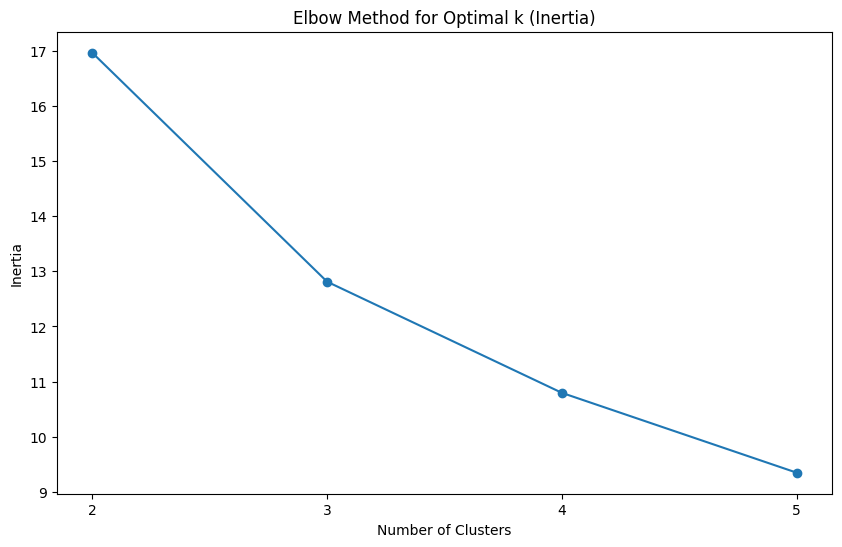

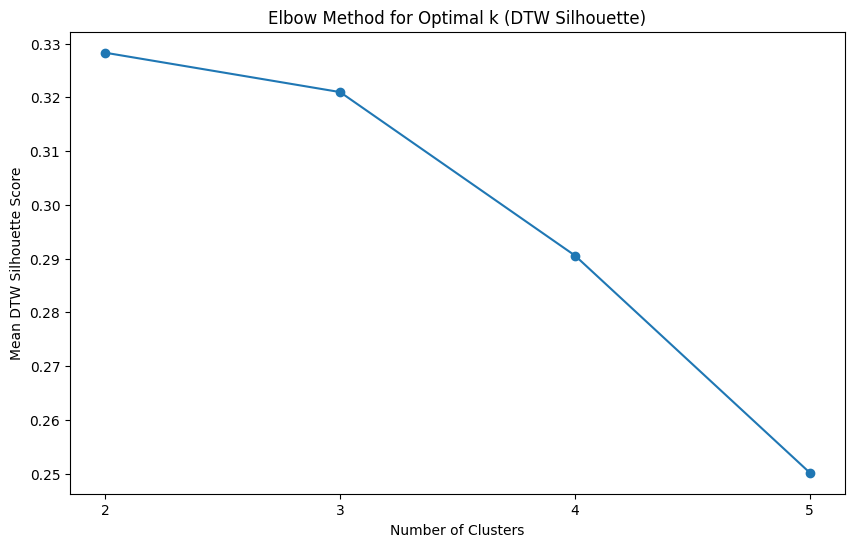

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
import matplotlib.pyplot as plt

# ... (Your data loading and preprocessing code)

# Define the range of cluster numbers to test
min_clusters = 2
max_clusters = 5  # Or a suitable upper bound for your data
inertias = []
dtw_silhouette_scores = []
grouped = df.groupby("ID")
participant_ids = list(grouped.groups.keys())  # Ensure this matches the order used to build time_series_data
id_to_index = {pid: i for i, pid in enumerate(participant_ids)}
experiments = df['Experiment'].unique()

for n_clusters in range(min_clusters, max_clusters + 1):
    print("====================")
    print("Number of clusters:", n_clusters)
    
    # Clustering
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
    labels = model.fit_predict(time_series_data)
    inertias.append(model.inertia_) # Inertia is the sum of squared distances to the nearest cluster center.

    # Adding labels to the original DataFrame for analysis:
    df["cluster"] = df["ID"].map(dict(zip(grouped.groups.keys(), labels)))

    #DTW Silhouette
    dtw_silhouette_exp = []
    for exp in experiments:
        # Get participant IDs belonging to this experiment
        exp_ids = df.loc[df['Experiment'] == exp, 'ID'].unique()
        
        # Extract their original time series directly from df, no padding
        participant_series = []
        exp_labels = []
        
        for pid in exp_ids:
            # Extract participant's original data (sorted by time)
            p_data = df[df['ID'] == pid].sort_values('time')[feature_columns].values
            
            # Remove any rows that contain NaNs if present
            p_data = p_data[~np.isnan(p_data).any(axis=1)]
            
            if len(p_data) == 0:
                continue
            
            participant_series.append(p_data)
            p_index = id_to_index[pid]
            exp_labels.append(labels[p_index])
        
        dtw_sil = dtw_silhouette_score(participant_series, np.array(exp_labels))
        dtw_silhouette_exp.append(dtw_sil)
    dtw_silhouette_scores.append(np.nanmean(dtw_silhouette_exp))

# Plot the elbow method (Inertia)
plt.figure(figsize=(10, 6))
plt.plot(range(min_clusters, max_clusters + 1), inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k (Inertia)')
plt.xticks(range(min_clusters, max_clusters + 1))
plt.show()

#Plot the elbow method (DTW Silhouette)
plt.figure(figsize=(10, 6))
plt.plot(range(min_clusters, max_clusters + 1), dtw_silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Mean DTW Silhouette Score')
plt.title('Elbow Method for Optimal k (DTW Silhouette)')
plt.xticks(range(min_clusters, max_clusters + 1))
plt.show()